#  Customer Churn Prediction with XGBoost

### Using Gradient Boosted Trees to Predict Mobile Customer Departure

### Business and the Problem Understanding

We all understand that losing customers is costly for any business. Identifying unhappy customers early on gives you a chance to offer them incentives to stay. This project describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this project is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

### Install All Libraries 

In [1]:
# !pip install -r requirements.txt

### Load libraries

In [2]:
import boto3
import re
import io
import os
import sys
import time
import json

import sagemaker
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display import display
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

from time import strftime, gmtime


%matplotlib inline

In [3]:
# Sets the value of the display.max_columns to 25.
pd.set_option('display.max_columns', 25)

### Data Acquisition

In [4]:
# Download churn dataset
!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt ./

download: s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt to ./churn.txt


### Data Understanding

In [5]:
# Read downloaded file into DataFrame churn.
churn = pd.read_csv('./churn.txt')

# Check the dimensionality of the churn DataFrame.
churn.shape

(5000, 21)

In [6]:
# Use head function to quickly test our churn DataFrame has the relevant type of data in it. 
churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.


By modern standards, it’s a relatively small dataset, with only 5,000 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

Familiarize with churn DataFrame attributes.

State: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ

Account Length: the number of days that this account has been active

Area Code: the three-digit area code of the corresponding customer’s phone number

Phone: the remaining seven-digit phone number

Int’l Plan: whether the customer has an international calling plan: yes/no

VMail Plan: whether the customer has a voice mail feature: yes/no

VMail Message: presumably the average number of voice mail messages per month

Day Mins: the total number of calling minutes used during the day

Day Calls: the total number of calls placed during the day

Day Charge: the billed cost of daytime calls

Eve Mins, Eve Calls, Eve Charge: the billed cost for calls placed during the evening

Night Mins, Night Calls, Night Charge: the billed cost for calls placed during nighttime

Intl Mins, Intl Calls, Intl Charge: the billed cost for international calls

CustServ Calls: the number of calls placed to Customer Service

Churn?: whether the customer left the service: true/false

The last attribute, Churn?, is known as the target attribute–the attribute that we want the ML model to predict. Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

### Data Exploration

In [7]:
# Print a concise summary of churn DataFrame, including the index dtype and columns, non-null values and memory usage.
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           5000 non-null   object 
 1   Account Length  5000 non-null   int64  
 2   Area Code       5000 non-null   int64  
 3   Phone           5000 non-null   object 
 4   Int'l Plan      5000 non-null   object 
 5   VMail Plan      5000 non-null   object 
 6   VMail Message   5000 non-null   int64  
 7   Day Mins        5000 non-null   float64
 8   Day Calls       5000 non-null   int64  
 9   Day Charge      5000 non-null   float64
 10  Eve Mins        5000 non-null   float64
 11  Eve Calls       5000 non-null   int64  
 12  Eve Charge      5000 non-null   float64
 13  Night Mins      5000 non-null   float64
 14  Night Calls     5000 non-null   int64  
 15  Night Charge    5000 non-null   float64
 16  Intl Mins       5000 non-null   float64
 17  Intl Calls      5000 non-null   i

In [8]:
# Generate descriptive statistics of churn DataFrame, that include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.
churn.describe(include='all')

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
count,5000,5000.000000,5000.000000,5000,5000,5000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000
unique,51,NaN,NaN,4999,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,RI,NaN,NaN,614-5668,no,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False.
freq,120,NaN,NaN,2,2507,2512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2502
mean,NaN,101.675800,773.791400,NaN,NaN,NaN,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800,NaN
std,NaN,57.596762,63.470888,NaN,NaN,NaN,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217,NaN
min,NaN,1.000000,657.000000,NaN,NaN,NaN,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000,NaN
25%,NaN,52.000000,736.000000,NaN,NaN,NaN,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000,NaN
50%,NaN,102.000000,778.000000,NaN,NaN,NaN,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000,NaN
75%,NaN,151.000000,806.000000,NaN,NaN,NaN,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000,NaN


In [9]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))


col_0,% observations
State,
AK,0.0170
AL,0.0200
AR,0.0220
AZ,0.0180
CA,0.0208
CO,0.0182
CT,0.0178
DC,0.0224
DE,0.0182


col_0,% observations
Phone,
100-2030,0.0002
100-2118,0.0002
100-3505,0.0002
100-5224,0.0002
101-3371,0.0002
...,...
999-3178,0.0002
999-5498,0.0002
999-5816,0.0002


col_0,% observations
Int'l Plan,
no,0.5014
yes,0.4986


col_0,% observations
VMail Plan,
no,0.4976
yes,0.5024


col_0,% observations
Churn?,
False.,0.5004
True.,0.4996


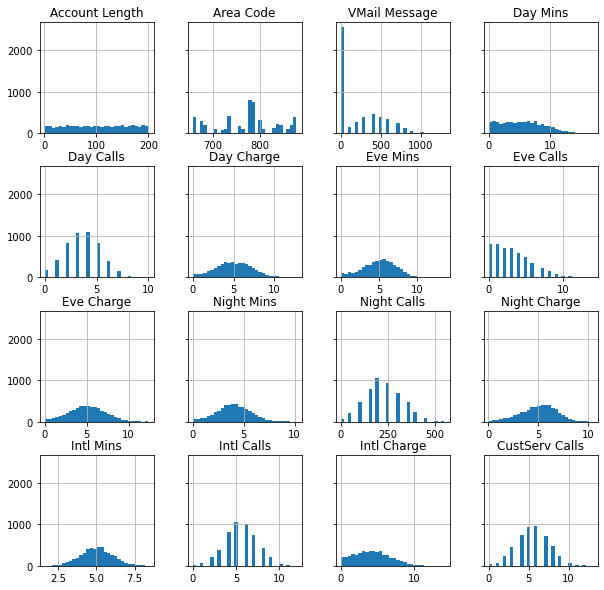

In [10]:
# Make a histogram of the churn's each numeric feature.
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))


We can see immediately that:

Phone takes on too many unique values to be of any practical use. It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.

Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity. VMail Message being a notable exception (and Area Code showing up as a feature we should convert to non-numeric).

In [11]:
churn = churn.drop('Phone', axis=1)
churn['Area Code'] = churn['Area Code'].astype(object)

Next let's look at the relationship between each of the features and our target variable.

In [12]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=churn[column], columns=churn['Churn?'], normalize='columns'))

Churn?,False.,True.
State,,
AK,0.015588,0.018415
AL,0.021583,0.018415
AR,0.022782,0.021217
AZ,0.015588,0.020416
CA,0.020384,0.021217
CO,0.018785,0.017614
CT,0.015588,0.020016
DC,0.022382,0.022418
DE,0.018385,0.018014


Churn?,False.,True.
Area Code,,
657,0.037170,0.036829
658,0.022782,0.021217
659,0.015588,0.020416
676,0.020384,0.021217
677,0.018785,0.017614
678,0.015588,0.020016
686,0.040767,0.040432
707,0.019984,0.015612
716,0.017986,0.015212


Churn?,False.,True.
Int'l Plan,,
no,0.5,0.502802
yes,0.5,0.497198


Churn?,False.,True.
VMail Plan,,
no,0.496403,0.498799
yes,0.503597,0.501201


Account Length


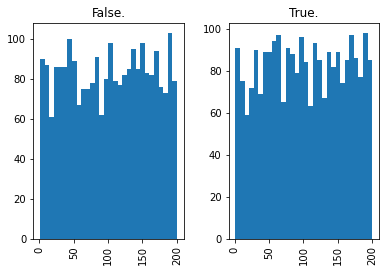

VMail Message


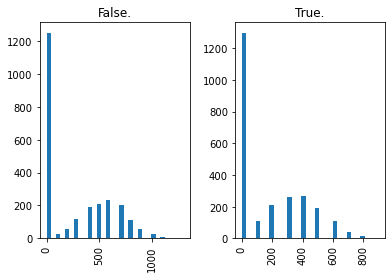

Day Mins


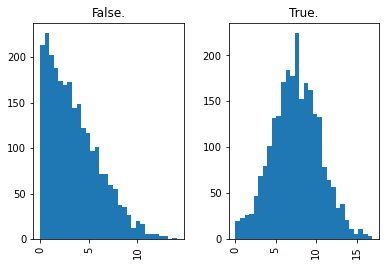

Day Calls


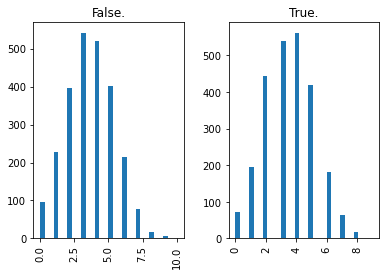

Day Charge


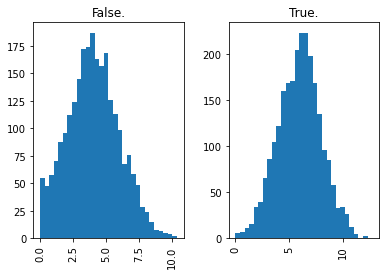

Eve Mins


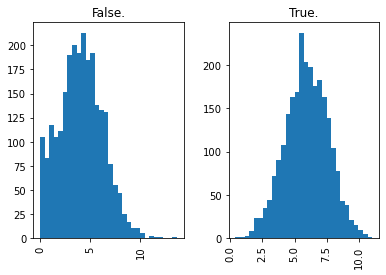

Eve Calls


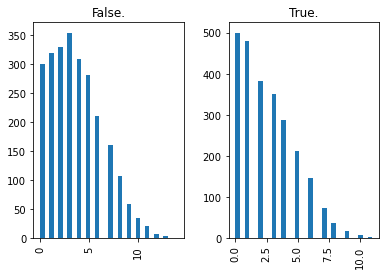

Eve Charge


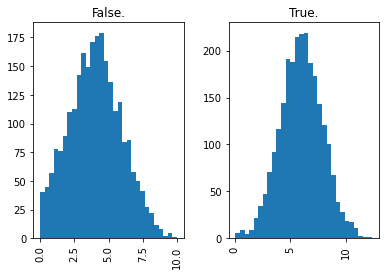

Night Mins


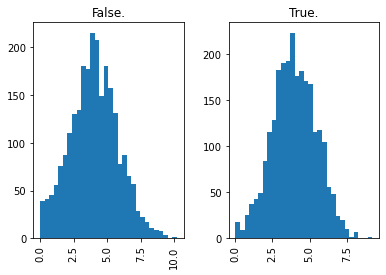

Night Calls


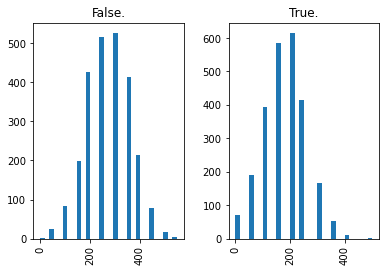

Night Charge


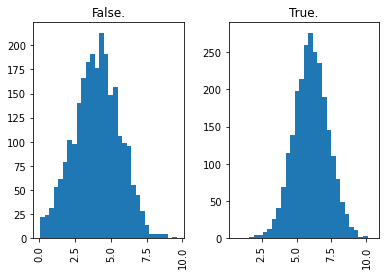

Intl Mins


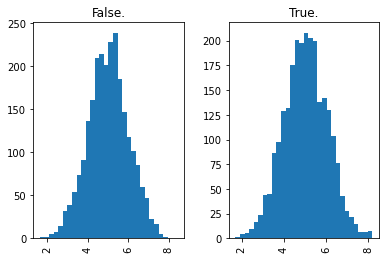

Intl Calls


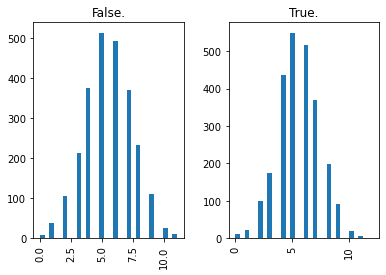

Intl Charge


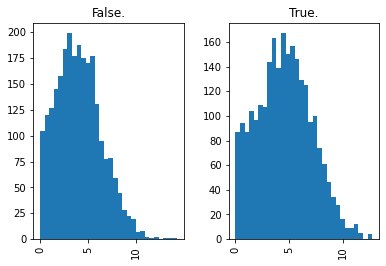

CustServ Calls


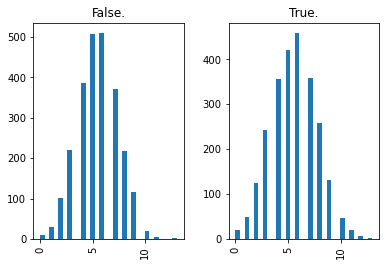

In [13]:
for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Churn?']].hist(by='Churn?', bins=30)
    plt.show()

In [14]:
corr_churn = churn.corr()
corr_churn 

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.009030,-0.015878,0.011659,-0.007468,0.000213,0.026515,-0.012795,0.016400,-0.002383,-0.034925,0.017277,-0.003735,0.028285,-0.036721
VMail Message,-0.009030,1.000000,-0.143272,0.002762,-0.182712,-0.104667,-0.101240,-0.029212,0.061370,0.135042,-0.155475,-0.015162,0.131964,0.010120,0.068657
Day Mins,-0.015878,-0.143272,1.000000,-0.087598,0.667941,0.482641,-0.184939,0.766489,0.188190,-0.445212,0.570508,0.001988,0.236131,0.239331,-0.195322
Day Calls,0.011659,0.002762,-0.087598,1.000000,-0.222556,0.033903,0.185881,-0.052051,-0.085222,-0.083050,0.046641,-0.022548,-0.045671,-0.120064,-0.065518
Day Charge,-0.007468,-0.182712,0.667941,-0.222556,1.000000,0.574697,0.236626,0.371580,0.150700,-0.130722,0.374861,0.010294,0.119584,0.251748,-0.260945
Eve Mins,0.000213,-0.104667,0.482641,0.033903,0.574697,1.000000,-0.067123,0.269980,-0.090515,0.067315,0.317481,-0.015678,0.070456,0.448910,-0.167347
Eve Calls,0.026515,-0.101240,-0.184939,0.185881,0.236626,-0.067123,1.000000,-0.467814,0.221439,0.218149,-0.324936,-0.001593,-0.112062,0.017036,-0.433467
Eve Charge,-0.012795,-0.029212,0.766489,-0.052051,0.371580,0.269980,-0.467814,1.000000,0.184230,-0.454649,0.546137,-0.003569,0.164104,0.243936,-0.011019
Night Mins,0.016400,0.061370,0.188190,-0.085222,0.150700,-0.090515,0.221439,0.184230,1.000000,-0.223023,-0.140482,-0.012781,0.038831,0.271179,-0.332802
Night Calls,-0.002383,0.135042,-0.445212,-0.083050,-0.130722,0.067315,0.218149,-0.454649,-0.223023,1.000000,-0.390333,-0.009821,0.181237,-0.155736,0.110211


<AxesSubplot:>

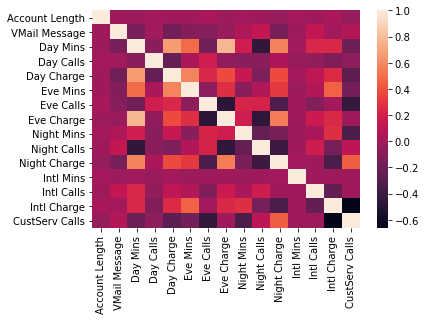

In [15]:
# plot the heatmap
sns.heatmap(corr_churn,
        xticklabels=corr_churn.columns,
        yticklabels=corr_churn.columns)

In [16]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr_churn.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.00,-0.01,-0.02,0.01,-0.01,0.00,0.03,-0.01,0.02,-0.00,-0.03,0.02,-0.00,0.03,-0.04
VMail Message,-0.01,1.00,-0.14,0.00,-0.18,-0.10,-0.10,-0.03,0.06,0.14,-0.16,-0.02,0.13,0.01,0.07
Day Mins,-0.02,-0.14,1.00,-0.09,0.67,0.48,-0.18,0.77,0.19,-0.45,0.57,0.00,0.24,0.24,-0.20
Day Calls,0.01,0.00,-0.09,1.00,-0.22,0.03,0.19,-0.05,-0.09,-0.08,0.05,-0.02,-0.05,-0.12,-0.07
Day Charge,-0.01,-0.18,0.67,-0.22,1.00,0.57,0.24,0.37,0.15,-0.13,0.37,0.01,0.12,0.25,-0.26
Eve Mins,0.00,-0.10,0.48,0.03,0.57,1.00,-0.07,0.27,-0.09,0.07,0.32,-0.02,0.07,0.45,-0.17
Eve Calls,0.03,-0.10,-0.18,0.19,0.24,-0.07,1.00,-0.47,0.22,0.22,-0.32,-0.00,-0.11,0.02,-0.43
Eve Charge,-0.01,-0.03,0.77,-0.05,0.37,0.27,-0.47,1.00,0.18,-0.45,0.55,-0.00,0.16,0.24,-0.01
Night Mins,0.02,0.06,0.19,-0.09,0.15,-0.09,0.22,0.18,1.00,-0.22,-0.14,-0.01,0.04,0.27,-0.33
Night Calls,-0.00,0.14,-0.45,-0.08,-0.13,0.07,0.22,-0.45,-0.22,1.00,-0.39,-0.01,0.18,-0.16,0.11


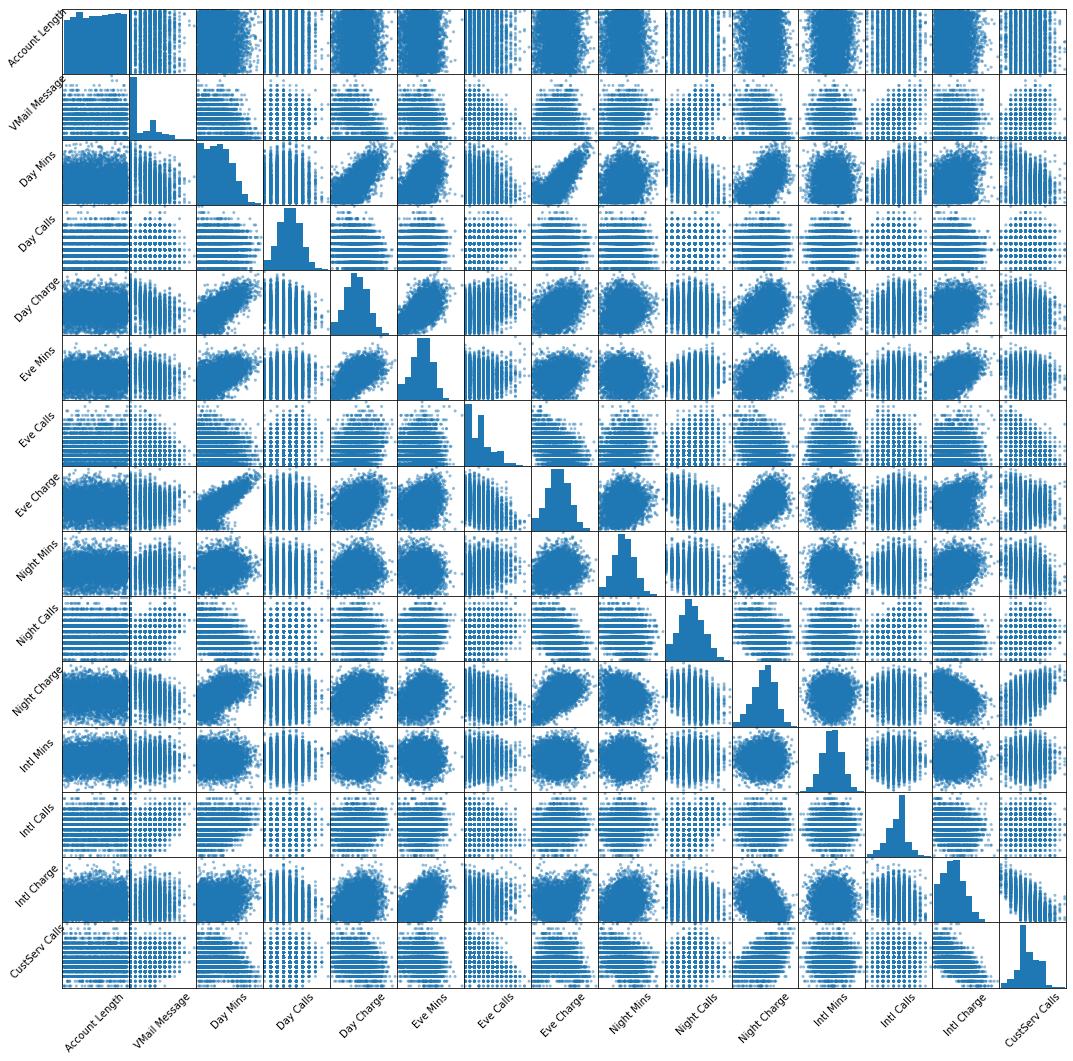

In [17]:
sm = pd.plotting.scatter_matrix(churn, figsize=(18, 18))

#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

In [18]:
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

In [19]:
model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)
model_data

,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,...,Area Code_847,Area Code_848,Area Code_858,Area Code_866,Area Code_868,Area Code_876,Area Code_877,Area Code_878,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,1,163,300,8.162204,3,3.933035,4,4.065759,100,4.928160,6,3,...,0,0,0,0,0,0,0,0,1,0,0,1
1,0,15,0,10.018993,4,2.325005,0,7.141040,200,3.221748,6,8,...,0,0,0,0,0,0,0,0,0,1,1,0
2,0,131,300,4.708490,3,4.537466,3,5.363235,100,7.139023,2,4,...,0,0,0,0,0,0,0,0,1,0,0,1
3,0,75,700,1.268734,3,2.528748,5,3.773586,450,2.245779,6,6,...,0,0,0,0,0,0,0,1,0,1,0,1
4,1,146,0,2.696177,3,6.015337,3,3.751673,250,6.905545,4,6,...,0,0,0,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,4,800,10.862632,5,6.936164,1,4.921314,350,4.872570,8,9,...,0,0,0,0,0,0,0,0,0,1,0,1
4996,0,140,0,1.581127,8,7.377591,7,0.939932,300,6.938571,2,4,...,0,0,0,0,0,0,0,0,1,0,1,0
4997,0,32,700,0.163836,5,5.841852,3,0.939469,450,4.388328,7,6,...,0,0,0,0,0,0,0,0,1,0,0,1
4998,1,142,600,2.034454,5,4.140554,3,6.076043,150,7.173376,3,7,...,0,0,0,0,0,0,0,0,0,1,0,1



Split the data into training, validation, and test sets. This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen. 

In [20]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

### Load Train and Validation Data to S3

In [22]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'sagemaker/project-xgboost-customer-churn'

In [24]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [25]:
print(os.path)

<module 'posixpath' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/posixpath.py'>


In [26]:
print(sess.default_bucket())

sagemaker-us-east-1-394321864396
